In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from geopy.distance import great_circle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
file = 'data-sample.json'

In [3]:
with open (file, 'r') as json_file:
    data = json.load(json_file)

In [4]:
df = pd.json_normalize(data)
df

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,UserVar.branch_dest,UserVar.taskStatusLabel,UserVar.receiver_city,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus
0,2022-11-01 20:17:26 +0700,pacifiedLion0,2022-11-01 20:46:30 +0700,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,SRG,Success,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,13,CGK,COLF01
1,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 12:33:48 +0700,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,1.3,CGK,COLF01
2,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 13:41:57 +0700,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01
3,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 18:18:19 +0700,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,0.625,CGK,COLF01
4,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 10:51:49 +0700,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,MGL,Success,"BAGELEN,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329,2022-11-10 09:07:12 +0700,debonairPonie1,2022-11-10 09:38:04 +0700,done,Delivery,501af4e040a742e9e878,0.000000,0.000000,NaN,NaN,CGK,Success,"PALMERAH ,JAKARTA BA",ATASAN/STAFF/KARYAWAN/BAWAHAN,D10,1,CGK,COLF01
8330,2022-11-10 09:21:42 +0700,murkyThrushe3,2022-11-10 09:37:52 +0700,done,Delivery,5cc952d9e9f8066dbf24,110.352054,-7.892571,NaN,NaN,JOG,Failed,KOTA BANTUL,ALAMAT TIDAK LENGKAP service/ TIDAK DIKENAL,U01,1,TGR,COLF02
8331,2022-11-10 09:36:44 +0700,enragedCake7,2022-11-10 09:37:55 +0700,done,Delivery,1b136b5a3c60749eb571,105.664897,-5.359063,NaN,NaN,TKG,Success,MARGA SEKAMPUNG KAB.,YANG BERSANGKUTAN,D01,1.44,CGK,COLF01
8332,2022-11-10 07:25:40 +0700,lyingPaella2,2022-11-10 10:37:53 +0800,done,Delivery,e92e813c8539080c922e,119.877173,-8.513305,151000.0,False,KOE,Failed,"KOMODO,LABUAN BAJO",PENERIMA PINDAH ALAMAT,U03,0.6,CGK,COLF02


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8334 entries, 0 to 8333
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   taskCreatedTime                8334 non-null   object 
 1   taskAssignedTo                 8333 non-null   object 
 2   taskCompletedTime              7566 non-null   object 
 3   taskStatus                     8334 non-null   object 
 4   flow                           8334 non-null   object 
 5   taskId                         8334 non-null   object 
 6   taskLocationDone.lon           7566 non-null   float64
 7   taskLocationDone.lat           7566 non-null   float64
 8   cod.amount                     2358 non-null   float64
 9   cod.received                   2358 non-null   object 
 10  UserVar.branch_dest            8334 non-null   object 
 11  UserVar.taskStatusLabel        7572 non-null   object 
 12  UserVar.receiver_city          8282 non-null   o

As we can see there are several columns with missing values. We will try to breakdown the missing values one by one.

cod.amount and cod.received tell us about how much the amount of CoD and the CoD has been received or not. If the value is empty, it means that the transaction's payment method isn't CoD system. It could be by transfer or something else. Then we will handle the missing values of both columns by fill it with 0 and 'False'

"taskCompletedTime", "taskLocationDone.lon", and "taskLocationDone.lat" tell us about when and where the task is completed. 

## Task Duration Analysis

Task Duration Analysis: Calculate the duration of each task by subtracting the task's creation time from its completion time. This analysis can help identify the average or median task duration, identify outliers or unusually long/short tasks, and assess the efficiency of task completion.

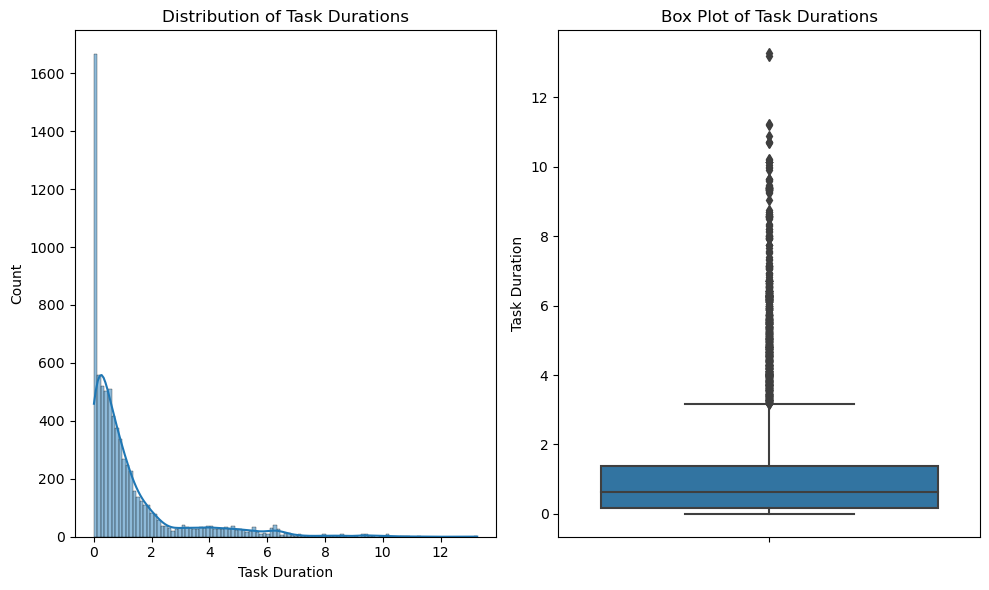

In [6]:
# Convert the taskCreatedTime and taskCompletedTime columns to datetime with UTC timezone
df['taskCreatedTime'] = pd.to_datetime(df['taskCreatedTime'], utc=True)
df['taskCompletedTime'] = pd.to_datetime(df['taskCompletedTime'], utc=True)

# Convert weight feature to float
df['UserVar.weight'] = df['UserVar.weight'].astype(float)

# Calculate task duration
df['taskDuration'] = df['taskCompletedTime'] - df['taskCreatedTime']

# Convert taskDuration to numeric data type
df['taskDuration'] = df['taskDuration'].dt.total_seconds()/3600

# Plotting Task Duration Analysis
plt.figure(figsize=(10, 6))

# Histogram of task durations
plt.subplot(1, 2, 1)
sns.histplot(df['taskDuration'], kde=True)
plt.xlabel('Task Duration')
plt.ylabel('Count')
plt.title('Distribution of Task Durations')

# Box plot of task durations
plt.subplot(1, 2, 2)
boxplot = sns.boxplot(y=df['taskDuration'])
plt.ylabel('Task Duration')
plt.title('Box Plot of Task Durations')

plt.tight_layout()
plt.show()

From both of those graphs. We could get several insights:
1. Task Completion Efficiency: The right-skewed distribution means the majority of the task are completed quickly. The majority of the task handled promptly, potentially resulting in higher customer satisfaction and timely service delivery.
2. Resources efficiency: Since most of the task are completed quickly. It means that current resources could handle the task pretty efficiently.
3. Indetifying Outliers: There are still several outliers which took longer hours compared to the average, ranging from 4 all the way up to 12 hours. These outliers need to be analysed separately to know what the problem was? Why did it take longer to completed compared to the average?.

### Outlier Analysis

#### Workers with longest hour needed to complete tasks

In [7]:
# Calculate the interquartile range (IQR)
Q1 = df['taskDuration'].quantile(0.25)
Q3 = df['taskDuration'].quantile(0.75)
IQR = Q3 - Q1

# Set the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to include only the outliers
outlier_data = df[(df['taskDuration'] < lower_bound) | (df['taskDuration'] > upper_bound)]
non_outlier_data = df[(df['taskDuration'] > lower_bound) | (df['taskDuration'] < upper_bound)]
outlier_data = pd.DataFrame(outlier_data)
non_outlier_data = pd.DataFrame(non_outlier_data)

outlier_data['taskAssignedTo'].value_counts().reset_index().rename(columns={'index':'AssignedTo',
                                                                           'taskAssignedTo':'Count'}).head()

,AssignedTo,Count
0,affectedKitten8,41
1,soreTomatoe9,30
2,emptyIcecream6,28
3,wornoutEggs4,24
4,peacefulVenison0,21


In [8]:
test = outlier_data['taskAssignedTo'].value_counts().reset_index().rename(columns={'index':'AssignedTo',
                                                                           'taskAssignedTo':'Count'}).head()
test['AssignedTo'].unique()

array(['affectedKitten8', 'soreTomatoe9', 'emptyIcecream6',
       'wornoutEggs4', 'peacefulVenison0'], dtype=object)

As we can see these are top 5 workers who have task duration falls in outlier zone.

#### Destination with longest hour needed to complete task

In [9]:
outlier_data.groupby(['UserVar.branch_dest']).size().reset_index().sort_values(by = 0,ascending=False).rename(columns={'UserVar.branch_dest':'Destination',
                                                                                                                      0:'count'}).head()

,Destination,count
31,MGL,95
3,BDO,81
14,CLG,75
12,CGK,67
48,SRG,50


As we can see those 5 branches are the branches that fall into outlier zone.

#### Weight of product in outlier zone

Text(0.5, 1.0, 'Distribution of Weight (outlier)')

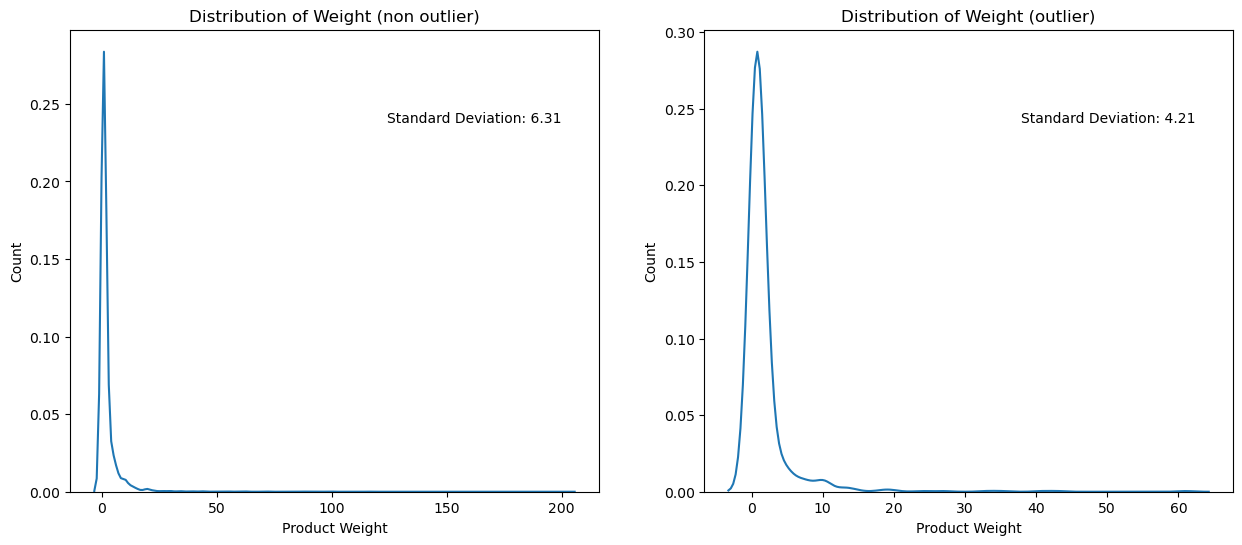

In [10]:
# Plotting Task Duration Analysis
plt.figure(figsize=(15, 6))

# Histogram of task durations
plt.subplot(1, 2, 1)
sns.kdeplot(non_outlier_data['UserVar.weight'])
plt.xlabel('Product Weight')
plt.ylabel('Count')
std_dev = non_outlier_data['UserVar.weight'].std()
plt.gca().text(0.6, 0.8, f'Standard Deviation: {std_dev:.2f}', transform=plt.gca().transAxes)
plt.title('Distribution of Weight (non outlier)')

plt.subplot(1, 2, 2)
sns.kdeplot(outlier_data['UserVar.weight'])
plt.xlabel('Product Weight')
plt.ylabel('Count')
std_dev = outlier_data['UserVar.weight'].std()
plt.gca().text(0.6, 0.8, f'Standard Deviation: {std_dev:.2f}', transform=plt.gca().transAxes)
plt.title('Distribution of Weight (outlier)')

As we can see the data that falls in outlier zone tends to have smaller standard deviation than the counterpart. It means that the weight of the product that has longer task duration tends to be in lower weight.

## Task Status Analysis

Task Status Analysis: Explore the distribution of task statuses to understand the overall performance. You can calculate the percentage of tasks marked as "done," "in progress," or "pending." This analysis can help identify bottlenecks or areas that require improvement in task management and completion.

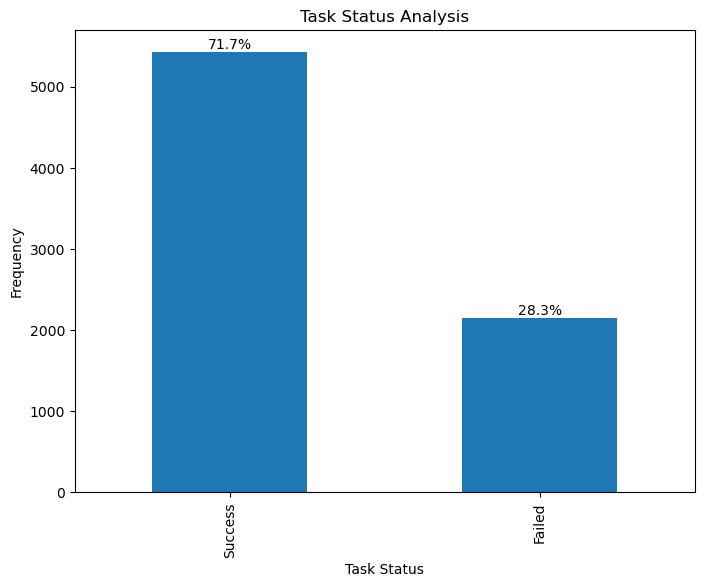

In [11]:
# Count the frequency of each task status label
status_counts = df['UserVar.taskStatusLabel'].value_counts()

# Calculate the percentage of successful and failed deliveries
total_deliveries = status_counts.sum()
successful_deliveries = status_counts['Success']
failed_deliveries = status_counts['Failed']
success_percentage = (successful_deliveries / total_deliveries) * 100
failure_percentage = (failed_deliveries / total_deliveries) * 100

# Plotting Task Status Analysis
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar')
plt.xlabel('Task Status')
plt.ylabel('Frequency')
plt.title('Task Status Analysis')

# Annotate the percentages on the bars
plt.text(0, status_counts['Success'], f'{success_percentage:.1f}%', ha='center', va='bottom')
plt.text(1, status_counts['Failed'], f'{failure_percentage:.1f}%', ha='center', va='bottom')

plt.show()

As we can see from the graph above, we can coclude several insights:
1. Most tasks are marked as "success" indicates a high completion rate. It suggests that the majority of tasks are being successfully completed within the expected timeframe. This can be a positive indicator of efficiency and effectiveness in task management.
2. The higher number of tasks marked as "Success" implies that the workflow or processes in place are generally efficient. It could means that the workflow is efficient enough that most of the tasks are already done.
3. There are 28.3% tasks marked as "Failed". This number is a little bit high for a "Failed" task so we need to do further analysis of why those tasks can be failed.

Next I'll try to analyze the characteristics of failed task

### Task Failed Analysis

In [12]:
task_failed = df[df['UserVar.taskStatusLabel'] == 'Failed']
task_success = df[df['UserVar.taskStatusLabel'] == 'Success']

In [13]:
task_success.describe()

,taskLocationDone.lon,taskLocationDone.lat,cod.amount,UserVar.weight,taskDuration
count,5421.000000,5421.000000,7.390000e+02,5427.00000,5421.000000
mean,78.713590,-3.935089,1.391527e+05,2.84180,1.550287
std,50.823398,3.650776,1.878955e+05,6.97327,1.814971
min,0.000000,-10.493658,8.370000e+02,0.00000,0.004167
25%,0.000000,-7.173321,3.967050e+04,1.00000,0.441667
50%,106.977430,-5.886562,9.340000e+04,1.00000,0.898056
75%,112.312455,0.000000,1.828750e+05,2.00000,1.804722
max,140.806424,5.564040,2.711000e+06,202.50000,13.266667


In [14]:
task_failed.describe()

,taskLocationDone.lon,taskLocationDone.lat,cod.amount,UserVar.weight,taskDuration
count,2145.000000,2145.000000,1.235000e+03,2145.000000,2145.000000
mean,66.869932,-2.790223,2.006836e+05,1.443627,0.364069
std,55.605349,3.507421,3.131134e+05,4.019199,0.798937
min,0.000000,-10.491860,2.955000e+03,0.000000,0.005833
25%,0.000000,-6.739677,7.156300e+04,0.550000,0.037500
50%,106.107953,-0.517458,1.580000e+05,1.000000,0.100000
75%,111.904243,0.000000,2.329750e+05,1.000000,0.341111
max,140.804728,3.734822,4.730000e+06,116.000000,6.737778


Text(0.5, 1.0, 'Distribution of Weight (Failed)')

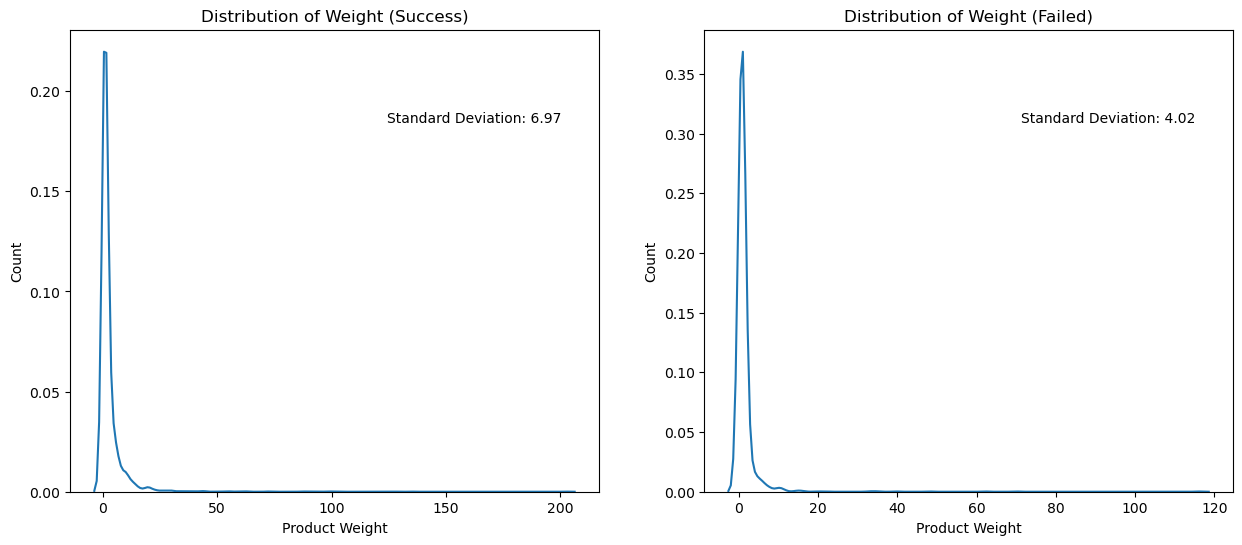

In [55]:
# Plotting Task Duration Analysis
plt.figure(figsize=(15, 6))

# Histogram of task durations
plt.subplot(1, 2, 1)
sns.kdeplot(task_success['UserVar.weight'])
plt.xlabel('Product Weight')
plt.ylabel('Count')
std_dev = task_success['UserVar.weight'].std()
plt.gca().text(0.6, 0.8, f'Standard Deviation: {std_dev:.2f}', transform=plt.gca().transAxes)
plt.title('Distribution of Weight (Success)')

plt.subplot(1, 2, 2)
sns.kdeplot(task_failed['UserVar.weight'])
plt.xlabel('Product Weight')
plt.ylabel('Count')
std_dev = task_failed['UserVar.weight'].std()
plt.gca().text(0.6, 0.8, f'Standard Deviation: {std_dev:.2f}', transform=plt.gca().transAxes)
plt.title('Distribution of Weight (Failed)')

From weight perspective. The task that was failed has lower standard deviation which means product with lower weight more likely to be fail than the higher weight.

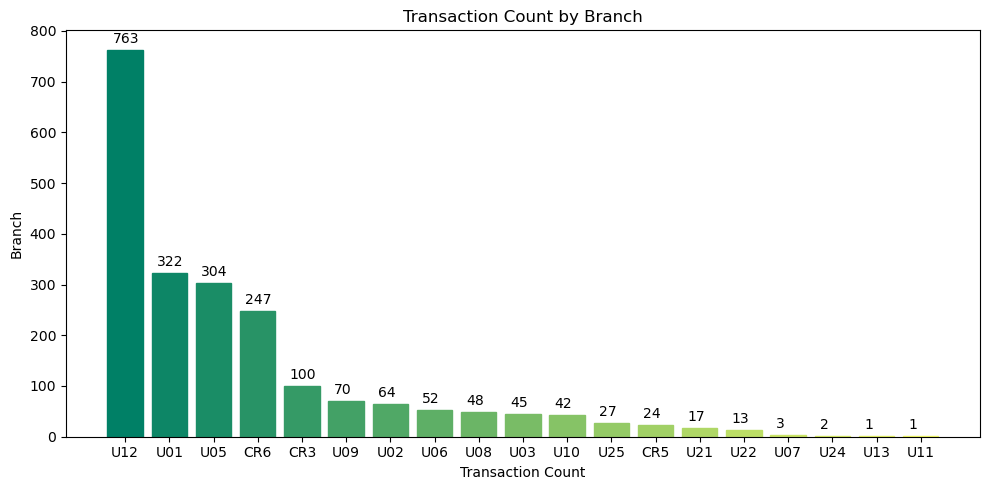

In [57]:
reason_count = task_failed['UserVar.taskDetailStatus'].value_counts().reset_index()

# Plot the reason failed using bar plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Create a gradient colormap
cmap = plt.cm.get_cmap('summer')

bars = ax1.bar(reason_count['index'], reason_count['UserVar.taskDetailStatus'])
ax1.set_xlabel('Transaction Count')
ax1.set_ylabel('Branch')
ax1.set_title('Transaction Count by Branch')

# Set the gradient color for the bars
for i, bar in enumerate(bars):
    bar.set_color(cmap(i / len(reason_count)))
    
# Annotate the value counts
for i, count in enumerate(reason_count['UserVar.taskDetailStatus']):
    ax1.annotate(f'{count}', (reason_count['index'][i], count), xytext=(-9, 5),
                 textcoords='offset points', color='black')
    
plt.tight_layout()
plt.show()

As we can see there are several reasons why the delivery failed. Most of it was because of U12 (Misroute), followed by U01 (Alamat tidak lengkap), and U05 (New Address).

In [17]:
task_failed['UserVar.taskDetailStatusLabel'].value_counts()

MISROUTE                                             763
ALAMAT TIDAK LENGKAP service/ TIDAK DIKENAL          322
RUMAH service/ KANTOR KOSONG (MASIH DIHUNI)          304
NEW ADDRESS                                          247
DIAMBIL SENDIRI                                      100
TUTUP PADA AKHIR PEKAN service/ HARI LIBUR            70
PENERIMA TIDAK DIKENAL                                64
DITOLAK OLEH PENERIMA                                 52
PENERIMA MENOLAK BAYAR (KIRIMAN COD)                  48
PENERIMA PINDAH ALAMAT                                45
FORCE MAJEURE                                         42
MENUNGGU PEMBAYARAN COD                               27
HOLD FOR FURTHER INSTRUCTI0N                          24
PENERIMA MENOLAK MENERIMA KIRIMAN COD (TDK PESAN)     17
TUTUP/LIBUR CUTI/DINAS LUAR KOTA (KIRIMAN COD)        13
RUMAH service/ KANTOR TIDAK DIHUNI                     3
MENUNGGU KONFIRMASI NILAI COD                          2
CRISS-CROSS                    

## Cash on Delivery Analysis

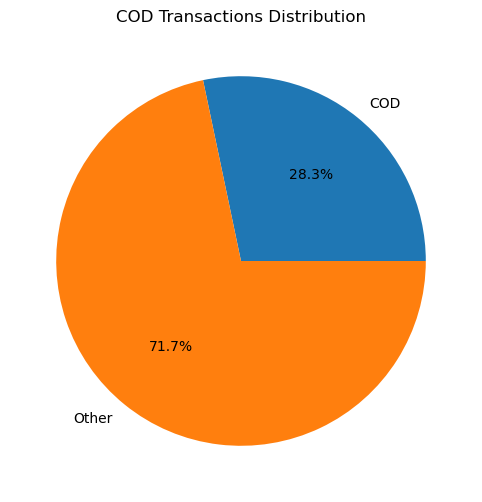

Total COD Frequency: 2358
COD Percentage: 28.29%
Total COD Amount: 450710675.0
Average COD Amount: 191141.08354537745


In [18]:
# Identify COD Transactions
cod_transactions = df[(df['cod.received'] == True) | (df['cod.received'] == False)]

# Calculate COD Frequency
cod_frequency = cod_transactions.shape[0]
total_transactions = df.shape[0]
cod_percentage = (cod_frequency / total_transactions) * 100

# Analyze COD Amounts
cod_amounts = cod_transactions['cod.amount']
total_cod_amount = cod_amounts.sum()
average_cod_amount = cod_amounts.mean()

# Visualize COD Analysis
plt.figure(figsize=(8, 6))
labels = ['COD', 'Other']
sizes = [cod_frequency, total_transactions - cod_frequency]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('COD Transactions Distribution')

plt.show()

print(f"Total COD Frequency: {cod_frequency}")
print(f"COD Percentage: {cod_percentage:.2f}%")
print(f"Total COD Amount: {total_cod_amount}")
print(f"Average COD Amount: {average_cod_amount}")

We could see that the majority of customers prefer non-COD payment methods. This could indicate that alternative payment options, such as online payments or credit/debit card transactions, are more popular and convenient for customers. It suggests that customers may prefer the convenience and security provided by non-COD payment methods.

## Geolocation Analysis

In [19]:
df_test = df['UserVar.branch_dest'].value_counts().reset_index()
df_test['percentage'] = df_test['UserVar.branch_dest'].cumsum() / df_test['UserVar.branch_dest'].sum()
df_test[df_test['percentage'] < 0.81]

,index,UserVar.branch_dest,percentage
0,PLM,562,0.067435
1,CGK,482,0.125270
2,SRG,480,0.182865
3,BDO,450,0.236861
4,KOE,432,0.288697
5,BOO,403,0.337053
6,PNK,309,0.374130
7,BPN,245,0.403528
8,DPS,244,0.432805
9,SUB,221,0.459323


In [20]:
# Group the data by branch and calculate the transaction count
branch_transaction_count = df['UserVar.branch_dest'].value_counts()

# Sort the branch-wise transaction count in descending order
branch_transaction_count = branch_transaction_count.sort_values(ascending=False)

# Calculate the cumulative percentage of transactions
cumulative_percentage = branch_transaction_count.cumsum() / branch_transaction_count.sum()

# Reverse the order of the branch-wise transaction count and cumulative percentage
branch_transaction_count = branch_transaction_count[::-1]
cumulative_percentage = cumulative_percentage[::-1]

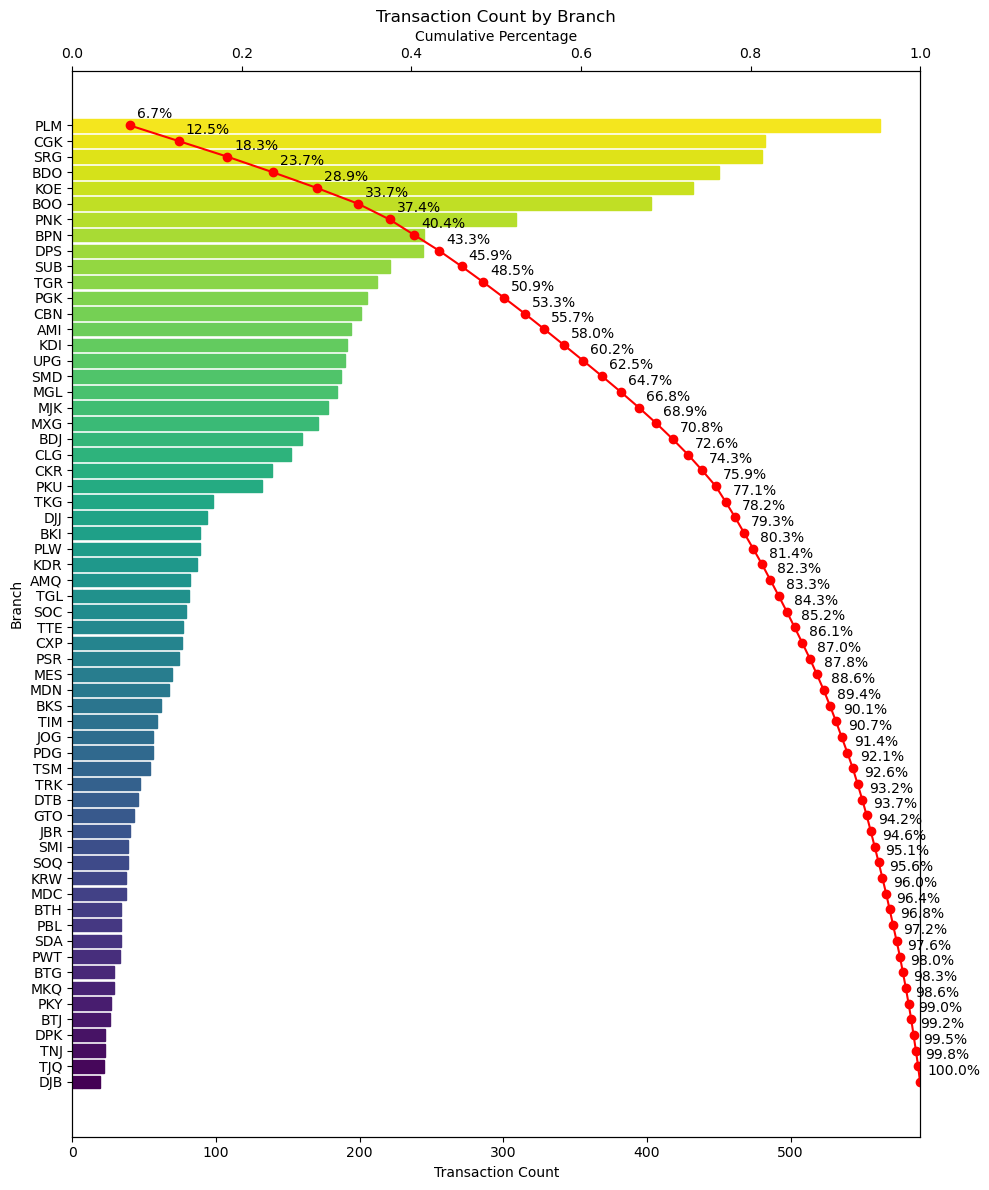

In [59]:
# Plot the branch-wise transaction count and cumulative percentage using a horizontal bar plot
fig, ax1 = plt.subplots(figsize=(10, 12))

# Create a gradient colormap
cmap = plt.cm.get_cmap('viridis')

bars = ax1.barh(branch_transaction_count.index, branch_transaction_count)
ax1.set_xlabel('Transaction Count')
ax1.set_ylabel('Branch')
ax1.set_title('Transaction Count by Branch')

# Set the gradient color for the horizontal bars
for i, bar in enumerate(bars):
    bar.set_color(cmap(i / len(branch_transaction_count)))

ax2 = ax1.twiny()
ax2.plot(cumulative_percentage, branch_transaction_count.index, color='red', marker='o')
ax2.set_xlabel('Cumulative Percentage')
ax2.set_xlim([0, 1])

# Annotate the cumulative percentage line with the percentage value
for i, percentage in enumerate(cumulative_percentage):
    ax2.annotate(f'{percentage:.1%}', (percentage, branch_transaction_count.index[i]), xytext=(5, 5),
                 textcoords='offset points', color='black')

plt.tight_layout()
plt.show()

The graph above shows the transaction count for each branches and the cumulative percentage of the transaction. According to The Pareto principle, also known as the 80/20 rule, suggests that roughly 80% of the effects come from 20% of the causes. So by focusing more on branches that account for 80% of the transactions, we can allocate our resources and efforts more efficiently. Instead of distributing our resources evenly across all branches, we can prioritize those key branches that generate the majority of the transactions. This approach allows you to maximize your impact and optimize your operations based on the Pareto principle.

## Task Assignment Analysis

### Task Distribution Analysis

In [22]:
# Calculate the number of tasks assigned to each person or entity
task_assignments = df['taskAssignedTo'].value_counts().reset_index()
# Assess the workload distribution
task_assignments

,index,taskAssignedTo
0,gutturalLion9,103
1,gloomyLlama0,83
2,zestyPear3,64
3,emptyIcecream6,57
4,artisticHyena7,56
...,...,...
2782,emptyAntelope3,1
2783,finickyCoati6,1
2784,thriftyLion5,1
2785,somberHeron8,1


In [23]:
# Identify the top performers
top_performers = task_assignments.head(5)  # Get the top 5 performers
top_performers

,index,taskAssignedTo
0,gutturalLion9,103
1,gloomyLlama0,83
2,zestyPear3,64
3,emptyIcecream6,57
4,artisticHyena7,56


In [24]:
# Assess the balance of task assignments
balance = task_assignments.describe()
print(balance)

       taskAssignedTo
count     2787.000000
mean         2.989953
std          5.246738
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        103.000000


Text(0.5, 1.0, 'Distribution of Task Assignment')

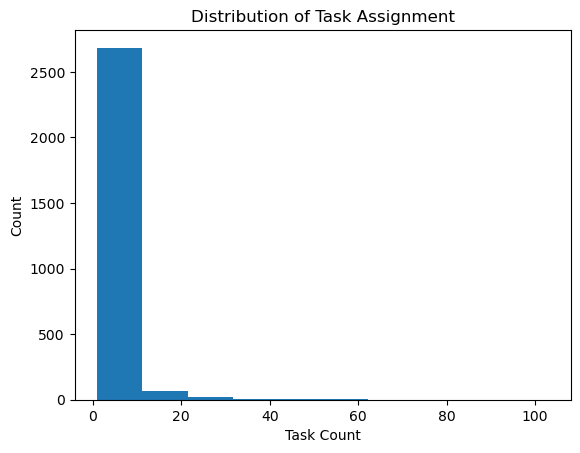

In [61]:
# Histogram of task durations
plt.subplot(1, 1, 1)
plt.hist(task_assignments['taskAssignedTo'])
plt.xlabel('Task Count')
plt.ylabel('Count')
plt.title('Distribution of Task Assignment')

As we can see there are several imbalance in term of workload. There are several workers who are assigned to a lot of task even more than hundred task while the other only has as little as 1 task. This means that there are so many underutilized workers. We could try to distribute the workload among the workers thus increasing the efficiency of their work.

### Task Assignment Efficiency

In [26]:
df_efficiency = df.groupby(['taskAssignedTo'])['taskDuration'].mean().reset_index().sort_values(by = ['taskDuration'],ascending=True)
df_efficiency = df_efficiency.dropna()
df_efficiency.reset_index(inplace=True,drop=True)
df_efficiency

,taskAssignedTo,taskDuration
0,aboardDunbird5,0.004722
1,unhappyCrackers3,0.005000
2,guiltySardines1,0.005000
3,brainyEagle1,0.005278
4,lovesickPiglet2,0.005278
...,...,...
2724,lyingSheep6,7.313611
2725,panickyMacaw8,9.417685
2726,madCheetah4,9.981528
2727,crummyCrane8,10.144802


In [27]:
### Checking the task duration of each top 5 workers with the most assigned task
df_efficiency[df_efficiency['taskAssignedTo'].isin(['gutturalLion9','gloomyLlama0','zestyPear3','emptyIcecream6','artisticHyena7'])]

,taskAssignedTo,taskDuration
191,gloomyLlama0,0.030981
236,gutturalLion9,0.048366
307,artisticHyena7,0.088517
1233,zestyPear3,0.730278
2302,emptyIcecream6,3.005210


As we can see 5 top performers with the most assigned task isn't the top performers in term of Task Duration. It could means that they are overloaded with their task thus make them perform poorly. That's why we need to distribute the workload more balance so each workers can perform more efficient.

## Product Analysis

In [28]:
df.describe()

,taskLocationDone.lon,taskLocationDone.lat,cod.amount,UserVar.weight,taskDuration
count,7566.000000,7566.000000,2.358000e+03,8334.000000,7566.000000
mean,75.355852,-3.610514,1.911411e+05,2.448298,1.213988
std,52.492016,3.647171,2.723770e+05,6.188171,1.681328
min,0.000000,-10.493658,8.370000e+02,0.000000,0.004167
25%,0.000000,-7.061575,6.100000e+04,1.000000,0.166597
50%,106.843097,-3.329263,1.533750e+05,1.000000,0.620972
75%,112.182877,0.000000,2.350000e+05,1.600000,1.368681
max,140.806424,5.564040,4.730000e+06,202.500000,13.266667


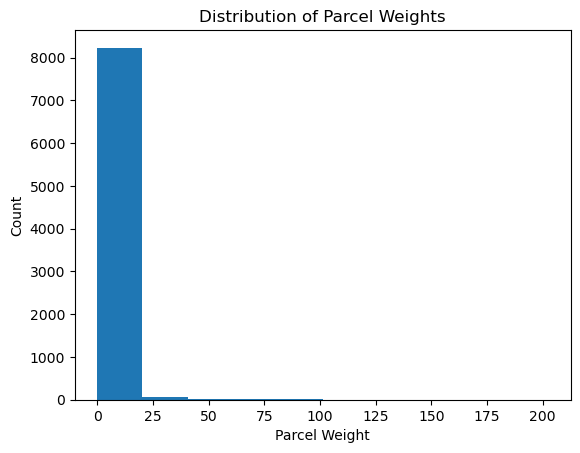

In [29]:
# Analyze the weight variable
# Convert the weight variable to float
df['UserVar.weight'] = df['UserVar.weight'].astype(float)
weight_counts = df['UserVar.weight'].value_counts().sort_index()

plt.hist(df['UserVar.weight'], bins=10)
plt.xlabel('Parcel Weight')
plt.ylabel('Count')
plt.title('Distribution of Parcel Weights')

plt.show()

From the graph above we could say that almost all of the product ordered are around 0-20 kg or lb while the biggest product ordered is weighing around 200 kg or lb.

## Machine Learning Model

Here we will try to create a machine learning model to predict how long the task duration will be.

### Feature Selection

From my knowledges, There are several factors that can affect how long the task duration will be. Based on this dataset, several columns that I will use as the features are "taskAssignedTo", "taskLocationDone.lon", "taskLocationDone.lat", "UserVar.weight", and "UserVar.branch_origin".

In [30]:
df_ml = df[["taskAssignedTo", "taskLocationDone.lon", "taskLocationDone.lat", "UserVar.weight", "UserVar.branch_origin", "taskDuration"]]
df_ml

,taskAssignedTo,taskLocationDone.lon,taskLocationDone.lat,UserVar.weight,UserVar.branch_origin,taskDuration
0,pacifiedLion0,109.762910,-6.926608,13.000,CGK,0.484444
1,peacefulTacos6,110.033986,-7.876154,1.300,CGK,3.878056
2,peacefulTacos6,109.999733,-7.849777,3.000,CGK,5.013889
3,peacefulTacos6,110.003708,-7.710998,0.625,CGK,9.620000
4,peacefulTacos6,110.013887,-7.829742,3.000,CGK,2.178333
...,...,...,...,...,...,...
8329,debonairPonie1,0.000000,0.000000,1.000,CGK,0.514444
8330,murkyThrushe3,110.352054,-7.892571,1.000,TGR,0.269444
8331,enragedCake7,105.664897,-5.359063,1.440,CGK,0.019722
8332,lyingPaella2,119.877173,-8.513305,0.600,CGK,2.203611


In [31]:
# Convert weight feature to float
df_ml['UserVar.weight'] = df_ml['UserVar.weight'].astype(float)

C:\Users\User\AppData\Local\Temp\ipykernel_15492\2934051502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['UserVar.weight'] = df_ml['UserVar.weight'].astype(float)


### Check Missing Value

In [32]:
# Check if there are any missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [33]:
missing_values_table(df_ml)

Dataframe has 6 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
taskLocationDone.lon,768,9.2
taskLocationDone.lat,768,9.2
taskDuration,768,9.2
UserVar.branch_origin,293,3.5
taskAssignedTo,1,0.0


Most of the missing values are caused by the task still being ongoing. Because we only need the task that had been done so we will drop data with missing value.

In [34]:
df_ml.dropna(inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_15492\772228459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml.dropna(inplace=True)


### Preprocessing Categorical Variable

The dataset we use has two categorical features which are "taskAssignedTo" and "UserVar.branch_origin". Because both of the features have too many values, using one hot encoder isn't visible. Instead we will use target encoder.

In [35]:
X = df_ml.drop(['taskDuration'], axis = 1)
y = df_ml['taskDuration']
# Create and fit the target encoder
encoder = TargetEncoder(cols=['taskAssignedTo','UserVar.branch_origin'])  # Specify the column(s) to encode
encoder.fit(X, y)

# Transform the categorical feature with target encoding
X = encoder.transform(X)

### Scaling the Data

In [36]:
# data standarization 
sc=StandardScaler()
X_scaled = sc.fit_transform(X)

### Modeling

As the baseline we will first try to model using linear regression.

#### Linear Regression

In [37]:
X_train_lr ,X_test_lr ,y_train_lr,y_test_lr = train_test_split(X_scaled,y,test_size=.2,random_state=42,shuffle=True)

In [38]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

# Make predictions on the testing set
y_pred = model.predict(X_test_lr)

# Evaluate the model
mse_lr = mean_squared_error(y_test_lr, y_pred)
r2_lr = r2_score(y_test_lr, y_pred)

print("Mean Squared Error:", mse_lr)
print("R-squared Score:", r2_lr)

Mean Squared Error: 1.4482018333040882
R-squared Score: 0.5117003641703709


As we can see the result is quite good but can be improved more. We will try using another algorithm.

#### Decision Tree

In [39]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_scaled,y,test_size=.2,random_state=42,shuffle=True)

In [40]:
dt = DecisionTreeRegressor(random_state=42)

##### Hyperparameter Tuning

In [41]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'max_depth':(1,2,3,4,5,6,7,8,9,10),
    'max_leaf_nodes' : (5,10,20,50,100)
}

# note: we use recall
dt_randomcv = RandomizedSearchCV(dt, parameters, cv=5, n_iter=10)
dt_randomcv.fit(X_train_dt, y_train_dt)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   param_distributions={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10),
                                        'max_leaf_nodes': (5, 10, 20, 50, 100)})

In [42]:
# the results
cv_result = pd.DataFrame(dt_randomcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
3,"{'max_leaf_nodes': 20, 'max_depth': 10}",0.733073,1
0,"{'max_leaf_nodes': 10, 'max_depth': 10}",0.723206,2
5,"{'max_leaf_nodes': 10, 'max_depth': 9}",0.723206,2
4,"{'max_leaf_nodes': 100, 'max_depth': 8}",0.717573,4
7,"{'max_leaf_nodes': 100, 'max_depth': 3}",0.712562,5
2,"{'max_leaf_nodes': 5, 'max_depth': 8}",0.689868,6
1,"{'max_leaf_nodes': 10, 'max_depth': 2}",0.683481,7
6,"{'max_leaf_nodes': 50, 'max_depth': 1}",0.592060,8
8,"{'max_leaf_nodes': 10, 'max_depth': 1}",0.592060,8
9,"{'max_leaf_nodes': 5, 'max_depth': 1}",0.592060,8


The best hyperparameter is with max_depth: 9 and max_leaf_nodes: 50

In [43]:
dt = DecisionTreeRegressor(random_state=42, max_depth=9, max_leaf_nodes=50)
dt.fit(X_train_dt, y_train_dt)
y_pred = dt.predict(X_test_dt)

# Evaluate the model
mse_dt = mean_squared_error(y_test_dt, y_pred)
r2_dt = r2_score(y_test_dt, y_pred)

print("Mean Squared Error:", mse_dt)
print("R-squared Score:", r2_dt)

Mean Squared Error: 0.7287182098741624
R-squared Score: 0.7542933392839752


#### Random Forest

In [44]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [45]:
rf = RandomForestRegressor(random_state=42)

##### Hyperparameter Tuning

In [46]:
parameters = {
    'n_estimators': (10,20,30,40,50,60,70,80,90,100),
    'max_depth': (1,2,3,4,5,6,7,8,9,10)
}

# note: we use recall
rf_randomcv = RandomizedSearchCV(rf, parameters, cv=5, n_iter=10)
rf_randomcv.fit(X_train_rf, y_train_rf)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10),
                                        'n_estimators': (10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100)})

In [47]:
# the results
cv_result = pd.DataFrame(rf_randomcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
8,"{'n_estimators': 60, 'max_depth': 10}",0.773134,1
7,"{'n_estimators': 50, 'max_depth': 9}",0.769248,2
6,"{'n_estimators': 100, 'max_depth': 9}",0.769123,3
3,"{'n_estimators': 100, 'max_depth': 8}",0.766692,4
9,"{'n_estimators': 30, 'max_depth': 7}",0.759787,5
5,"{'n_estimators': 60, 'max_depth': 6}",0.754778,6
2,"{'n_estimators': 40, 'max_depth': 6}",0.753193,7
4,"{'n_estimators': 20, 'max_depth': 4}",0.736377,8
1,"{'n_estimators': 60, 'max_depth': 3}",0.724073,9
0,"{'n_estimators': 10, 'max_depth': 2}",0.701005,10


The best hyperparameter is with max_depth: 10 and n_estimators: 40

In [48]:
rf = RandomForestRegressor(random_state=42, n_estimators=70, max_depth=9)
rf.fit(X_train_rf, y_train_rf)
y_pred_train = rf.predict(X_train_rf)
y_pred = rf.predict(X_test_rf)

# Evaluate the model
mse_rf = mean_squared_error(y_test_rf, y_pred)
r2_rf = r2_score(y_test_rf, y_pred)

print("Mean Squared Error:", mse_rf)
print("R-squared Score:", r2_rf)

Mean Squared Error: 0.6374845125433667
R-squared Score: 0.7850551986861127


#### XGBoost

In [49]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [50]:
# Create an XGBoost regressor
xgb_reg = xgb.XGBRegressor()

##### Hyperparameter Tuning

In [51]:
# hyperparameter tuning
parameters = {
    'max_depth': (6,7,8,9,10,20,30),
    'gamma': (0,1,2,3,4,5,10,20)
}

# now we use recall (sensitivity) as metric
xgb_rcv = RandomizedSearchCV(xgb_reg, parameters, cv=5)
xgb_rcv.fit(X_train_xgb, y_train_xgb)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'gamma': (0, 1, 2, 3, 4, 5, 10, 20),
                                        'max_depth': (6, 7, 8, 9, 10, 20, 30)})

In [52]:
# the compact results
cv_result = pd.DataFrame(xgb_rcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
5,"{'max_depth': 6, 'gamma': 3}",0.768166,1
1,"{'max_depth': 8, 'gamma': 10}",0.765274,2
9,"{'max_depth': 8, 'gamma': 3}",0.764783,3
4,"{'max_depth': 6, 'gamma': 4}",0.764164,4
8,"{'max_depth': 6, 'gamma': 1}",0.764147,5
0,"{'max_depth': 10, 'gamma': 10}",0.763273,6
2,"{'max_depth': 6, 'gamma': 10}",0.762370,7
6,"{'max_depth': 10, 'gamma': 2}",0.761579,8
7,"{'max_depth': 9, 'gamma': 4}",0.761279,9
3,"{'max_depth': 10, 'gamma': 3}",0.760631,10


The best hyperparameter is with max_depth: 7 and gamma: 10

In [53]:
xgb_reg = xgb.XGBRegressor(random_state=42, gamma=70, max_depth=7, objective='reg:squarederror')
xgb_reg.fit(X_train_xgb, y_train_xgb)
y_pred_train = xgb_reg.predict(X_train_xgb)
y_pred = xgb_reg.predict(X_test_xgb)

# Evaluate the model
mse_xgb = mean_squared_error(y_test_xgb, y_pred)
r2_xgb = r2_score(y_test_xgb, y_pred)

print("Mean Squared Error:", mse_xgb)
print("R-squared Score:", r2_xgb)

Mean Squared Error: 0.7158806859204201
R-squared Score: 0.7586218507714001


In [54]:
print("Mean Squared Error (Linear Regression):", round(mse_lr,2))
print("R-squared Score (Linear Regression):", round(r2_lr,2))
print("Mean Squared Error (Decision Tree):", round(mse_dt,2))
print("R-squared Score (Decision Tree):", round(r2_dt,2))
print("Mean Squared Error (Random Forest):", round(mse_rf,2))
print("R-squared Score (Random Forest):", round(r2_rf,2))
print("Mean Squared Error (XGBoost):", round(mse_xgb,2))
print("R-squared Score (XGBoost):", round(r2_xgb,2))

Mean Squared Error (Linear Regression): 1.45
R-squared Score (Linear Regression): 0.51
Mean Squared Error (Decision Tree): 0.73
R-squared Score (Decision Tree): 0.75
Mean Squared Error (Random Forest): 0.64
R-squared Score (Random Forest): 0.79
Mean Squared Error (XGBoost): 0.72
R-squared Score (XGBoost): 0.76
